<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem19_Mindlin_plate_in_free_vibrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 12 frequencies D:
 1: 4.3779363625e-01
 2: 9.1005888836e-01
 3: 9.1005888836e-01
 4: 1.3160044150e+00
 5: 1.7009164786e+00
 6: 1.7118791901e+00
 7: 2.0459472336e+00
 8: 2.0459472336e+00
 9: 2.6772672820e+00
10: 2.8820417300e+00
11: 2.8820417300e+00
12: 3.1436190253e+00


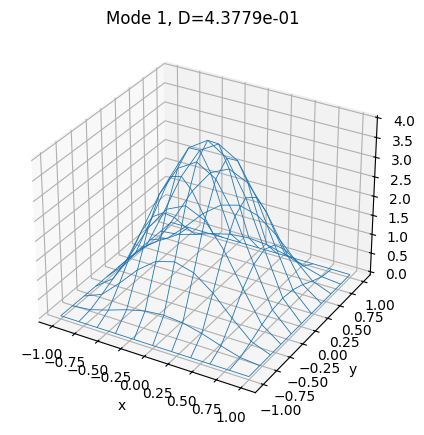

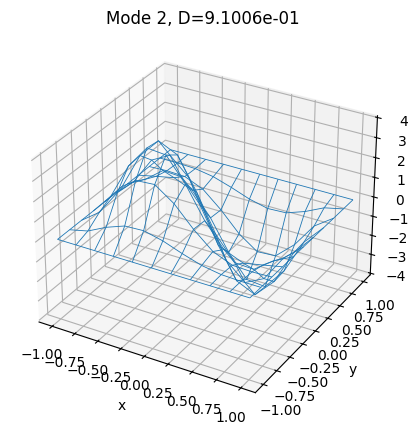

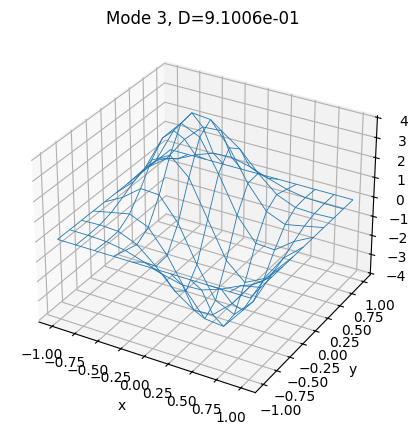

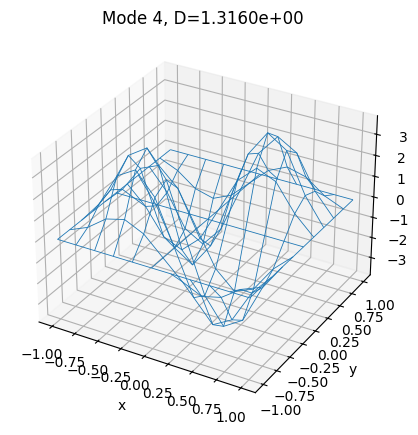

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ============================================================
# Q4 utilities
# ============================================================
def gaussQuadrature(option='complete'):
    if option == 'complete':  # 2x2
        a = 0.577350269189626
        locations = np.array([[-a, -a],
                              [ a, -a],
                              [ a,  a],
                              [-a,  a]], dtype=float)
        weights = np.array([1, 1, 1, 1], dtype=float)
    elif option == 'reduced':  # 1x1
        locations = np.array([[0.0, 0.0]], dtype=float)
        weights = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return weights, locations


def shapeFunctionQ4(xi, eta):
    N = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta)
    ], dtype=float)

    dN = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)]
    ], dtype=float)  # cols: d/dxi, d/deta
    return N, dN


def Jacobian(nodeCoords_elem, naturalDerivatives):
    J = nodeCoords_elem.T @ naturalDerivatives
    invJ = np.linalg.inv(J)
    XYder = naturalDerivatives @ invJ
    return J, invJ, XYder


def rectangularMesh(Lx, Ly, nEx, nEy, centered=False):
    if centered:
        xs = np.linspace(-Lx, Lx, nEx + 1)
        ys = np.linspace(-Ly, Ly, nEy + 1)
    else:
        xs = np.linspace(0.0, Lx, nEx + 1)
        ys = np.linspace(0.0, Ly, nEy + 1)

    X, Y = np.meshgrid(xs, ys)
    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def nid(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elems = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = nid(ix,   iy)
            n2 = nid(ix+1, iy)
            n3 = nid(ix+1, iy+1)
            n4 = nid(ix,   iy+1)
            elems.append([n1, n2, n3, n4])

    return nodeCoordinates, np.array(elems, dtype=int)


# ============================================================
# EssentialBC (from your screenshot)
# DOF order: w(1..N), tx(N+1..2N), ty(2N+1..3N)
# ============================================================
def EssentialBC(typeBC, GDoF, xx, yy, nodeCoordinates, numberNodes):
    xmin, xmax = np.min(nodeCoordinates[:, 0]), np.max(nodeCoordinates[:, 0])
    ymin, ymax = np.min(nodeCoordinates[:, 1]), np.max(nodeCoordinates[:, 1])

    on_left   = np.where(np.isclose(xx, xmin))[0] + 1
    on_right  = np.where(np.isclose(xx, xmax))[0] + 1
    on_bottom = np.where(np.isclose(yy, ymin))[0] + 1
    on_top    = np.where(np.isclose(yy, ymax))[0] + 1

    edges_all = np.unique(np.hstack([on_left, on_right, on_bottom, on_top]))
    bc = typeBC.lower()

    if bc == 'ssss':
        fixedNodeW  = edges_all
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedNodeTY = np.unique(np.hstack([on_left, on_right]))

    elif bc == 'cccc':
        fixedNodeW  = edges_all
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif bc == 'cccf':
        fixedNodeW  = np.unique(np.hstack([on_left, on_bottom, on_top]))
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif bc == 'scsc':
        fixedNodeW  = edges_all
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedNodeTY = np.array([1], dtype=int)  # small constraint to avoid rigid mode

    else:
        raise ValueError("typeBC must be one of: 'ssss','cccc','cccf','scsc'")

    prescribedDof = np.unique(np.hstack([
        fixedNodeW,
        fixedNodeTX + numberNodes,
        fixedNodeTY + 2*numberNodes
    ])).astype(int)

    allDof = np.arange(1, GDoF + 1, dtype=int)
    activeDof = np.setdiff1d(allDof, prescribedDof)

    return prescribedDof, activeDof, fixedNodeW


# ============================================================
# Mindlin plate stiffness K (same as problem18 bending)
# ============================================================
def formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, C_shear, C_bending):
    K = np.zeros((GDoF, GDoF), dtype=float)

    # bending: complete 2x2
    gw_b, gl_b = gaussQuadrature('complete')
    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_b)):
            xi, eta = gl_b[q, 0], gl_b[q, 1]
            wt = gw_b[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            B_b = np.zeros((3, 3*ndof), dtype=float)
            B_b[0, ndof:2*ndof]       = dN_xy[:, 0]  # d(tx)/dx
            B_b[1, 2*ndof:3*ndof]     = dN_xy[:, 1]  # d(ty)/dy
            B_b[2, ndof:2*ndof]       = dN_xy[:, 1]  # d(tx)/dy
            B_b[2, 2*ndof:3*ndof]     = dN_xy[:, 0]  # d(ty)/dx

            K[np.ix_(elementDof, elementDof)] += (B_b.T @ C_bending @ B_b) * wt * detJ

    # shear: reduced 1x1
    gw_s, gl_s = gaussQuadrature('reduced')
    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_s)):
            xi, eta = gl_s[q, 0], gl_s[q, 1]
            wt = gw_s[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            B_s = np.zeros((2, 3*ndof), dtype=float)
            # gamma_xz = dw/dx + tx
            B_s[0, 0:ndof]          = dN_xy[:, 0]
            B_s[0, ndof:2*ndof]     = N
            # gamma_yz = dw/dy + ty
            B_s[1, 0:ndof]          = dN_xy[:, 1]
            B_s[1, 2*ndof:3*ndof]   = N

            K[np.ix_(elementDof, elementDof)] += (B_s.T @ C_shear @ B_s) * wt * detJ

    return K


# ============================================================
# Mindlin plate mass matrix M (from your screenshot)
# - Gauss 'complete'
# - block diagonal for w, tx, ty with same N*N'
#   w: rho*thickness
#   tx,ty: rho*I
# ============================================================
def formMassMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                            nodeCoordinates, thickness, rho, I):
    M = np.zeros((GDoF, GDoF), dtype=float)
    gw, gl = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            wt = gw[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            NN = np.outer(N, N) * wt * detJ

            # w-w block
            M[np.ix_(nodes, nodes)] += NN * (thickness * rho)

            # tx-tx block
            tx = nodes + numberNodes
            M[np.ix_(tx, tx)] += NN * (I * rho)

            # ty-ty block
            ty = nodes + 2*numberNodes
            M[np.ix_(ty, ty)] += NN * (I * rho)

    return M


# ============================================================
# Plot eigenmodes (w only) similar to MATLAB drawEigenmodes2D
# ============================================================
def plot_mode_surface(x_grid, y_grid, w_grid, title):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(x_grid, y_grid, w_grid, rstride=1, cstride=1, linewidth=0.6)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("w")
    plt.show()


# ============================================================
# MAIN: problem19vibrations.m
# ============================================================

# materials
E = 10920.0
poisson = 0.30
thickness = 0.1
I = thickness**3 / 12.0
rho = 1.0

# kapa choices in your screenshot
# kapa=0.8601  # cccc / cccf case
# kapa=0.822   # scsc case
kapa = 5/6     # ssss case
# (Bạn đang dùng BC 'cccc' ở code => thường dùng kapa=0.8601 theo chú thích)
kapa_for_BC = 0.8601
kapa = kapa_for_BC

# constitutive matrices
C_bending = (I * E / (1 - poisson**2)) * np.array([
    [1, poisson, 0],
    [poisson, 1, 0],
    [0, 0, (1 - poisson)/2]
], dtype=float)

C_shear = (kapa * thickness * E / 2.0 / (1 + poisson)) * np.eye(2)

# mesh (note: MATLAB uses x,y in [-L, L])
L = 1.0
numberElementsX = 10
numberElementsY = 10
numberElements = numberElementsX * numberElementsY

nodeCoordinates, elementNodes = rectangularMesh(L, L, numberElementsX, numberElementsY, centered=True)
xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]
numberNodes = nodeCoordinates.shape[0]

# DOF
GDoF = 3 * numberNodes

# stiffness & mass
K = formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, C_shear, C_bending)

M = formMassMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                            nodeCoordinates, thickness, rho, I)

# boundary conditions (as screenshot)
prescribedDof, activeDof, fixedNodeW = EssentialBC('cccc', GDoF, xx, yy, nodeCoordinates, numberNodes)

# eigenproblem on active DOFs
active0 = activeDof - 1
Kaa = K[np.ix_(active0, active0)]
Maa = M[np.ix_(active0, active0)]

# Solve: K v = lambda M v
eigvals, eigvecs = eigh(Kaa, Maa)
eigvals = np.maximum(eigvals, 0.0)

# MATLAB: G=E/2.6;
G = E / 2.6

# MATLAB: D = diag(sqrt(D))*L*sqrt(rho/G)
D = np.sqrt(eigvals) * L * np.sqrt(rho / G)

# sort & keep first modes
numberOfModes = 12
idx = np.argsort(D)
idx = idx[:numberOfModes]
D = D[idx]
V = eigvecs[:, idx]  # columns = modes

print("First 12 frequencies D:")
for i, val in enumerate(D, 1):
    print(f"{i:2d}: {val:.10e}")

# Build VVV (w-only, like MATLAB block)
# activeDofW = setdiff([1:numberNodes]', [fixedNodeW])
activeDofW = np.setdiff1d(np.arange(1, numberNodes+1, dtype=int), fixedNodeW)
NNN = activeDofW.size

VVV = np.zeros((numberNodes, numberOfModes), dtype=float)

# In MATLAB they assume first NNN entries of V correspond to active w DOFs
# This holds because activeDof is sorted and w-DOFs come first.
for i in range(numberOfModes):
    VVV[activeDofW - 1, i] = V[:NNN, i]

# reshape for plotting (grid size = (nEy+1, nEx+1))
Nx = numberElementsX + 1
Ny = numberElementsY + 1
x_grid = xx.reshape(Ny, Nx)
y_grid = yy.reshape(Ny, Nx)

# plot a few mode shapes (w only)
for i in range(min(4, numberOfModes)):
    w_grid = VVV[:, i].reshape(Ny, Nx)
    plot_mode_surface(x_grid, y_grid, w_grid, title=f"Mode {i+1}, D={D[i]:.4e}")
